# Class 5: Gibbs sampling

---
# Before Class
In class today we will be implementing a Gibbs Sampler.

Prior to class, please do the following:
1. Review slides on Gibbs sampling in detail
1. Review or read up on Python syntax for:
      1. functions from previous class
      1. `numpy.random.randint()`
      1. `numpy.random.choice()`



---
## Learning Objectives

1. Implement gibbs sampler to locate motifs in B. subtilus promoters


---
## Imports

In [3]:
import sys
import os
import numpy as np
import seqlogo

#import function from previous class for building sequence motif & idenfitying seqs matching to motif
sys.path.insert(0, '../shared/')
from data_readers import *
from seq_ops import get_seq
from motif_ops import *


---
## Implement Gibbs Sampler


Gibbs sampling is a MCMC approach to identify enrichments. Here we will implement a method to identify motifs from a set of regions. 

Important considerations:
- We will need to score each sequence with a PWM using the `score_kmer()` or `score_nmer()` function from the previous class
- These sites are often not strand-specific and so both scores on the negative as well as positive strand should be considered
- To select a random sequence, use `numpy.random.randint()`
- To select a new position $m$ (as defined below) use `numpy.random.choice()`

Assumptions: 
- We know k as the length of expected motif
- Each sequence contains the motif



```
GibbsMotifFinder(DNA, k-length)
    random pick of k-length sequences from each line of DNA as Motifs
    for j ← 1 to 10000 or Motifs stops changing
        i ← Random(N) where N is number of DNA entries
        PWM ← PWM constructed from all Motifs except for Motifi
        Motifi ← select position m from PWM-scored k-mers in DNAi in probabilistic fashion from score distribution
    return Motifs
```

Probability of chosing position $m = \frac{A_{m}}{\sum_{l}A_{l}}$ for positions $l$ in DNAi


Note: I have also added a function to `motif_ops.py` that will calculate the information content of your motifs. This is useful to observe the progression of your Gibbs sampler as well as a measure of convergence. You can use this function as `IC = pfm_ic(pfm)`. You should expect a slow increase of IC until it plateaus such as in the plot below from your lecture slides:

<center><img src='./figures/Gibbs_Sampling.png'/ width=600px></center>

In [4]:
def GibbsMotifFinder (seqs,k):
    '''
    Function to find a pfm from a list of strings using a Gibbs sampler
    
    Args: 
        seqs (str list): a list of sequences, not necessarily in same lengths
        k (int): the length of motif to find

    Returns:
        pfm (numpy array): dimensions are 4xlength
        
    '''
    
    if type( k ) is not int:
        raise IOError( 'Invalid Parameter Type' )
    
    bg, motifs = 0.25, []
    
    for s in seqs:
        s_i = np.random.randint( len(s) - k )
        motifs.append( s[ s_i:s_i+k ] )
            
    for j in range( 10000 ):
        i = np.random.randint( len( motifs ) )
        motif, s = motifs.pop( i ), seqs.pop( i )
        
        #if np.random.randint(2) is 0:
        #    s = reverse_complement( s )
        
        pwm = build_pwm( build_pfm( motifs, k ) )
        scores = np.zeros( len(s)-k )
        
        for m_i in range( 0, len( s ) - k ):
            s_i = s[ m_i:m_i+k ]
            scores[m_i] = score_kmer( s_i, pwm )
            
        scores = ( 2**scores ) / np.sum( 2**scores )
        new_m = np.random.choice( len(s)-k, 1, p=scores )[0]
        
        motifs.insert( i, s[ new_m : new_m+k ] )
        seqs.insert( i, s )
        
    return build_pfm( motifs, k )


In [140]:
np.random.randint( 2 )

1

In [5]:
# Here we test your Gibbs sampler.

#read promoters from previous class, store in a list of strings
seq_file="../class_3/data/GCF_000009045.1_ASM904v1_genomic.fna.gz"
gff_file="../class_3/data/GCF_000009045.1_ASM904v1_genomic.gff.gz"

seqs = []
for name, seq in get_fasta(seq_file): # For each entry in our FASTA file
    for gff_entry in get_gff(gff_file): # For each entry in our GFF file
        if gff_entry.type == 'CDS': # If this is a coding sequence
            promoter_seq = get_seq(seq, gff_entry.start, gff_entry.end, gff_entry.strand, 50) # Extract 50 bp as a promoter

            # Because the gibbs sampling assumption is broken in just using promoters,
            #  and because it takes very long time to randomly progress through so many
            #  regions, for this example we will pre-filter for sequences that all contain
            #  part of the shine-dalgarno motif:
            if "AGGAGG" in promoter_seq:
                seqs.append(promoter_seq)


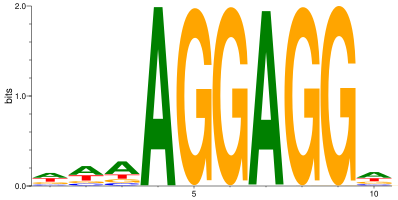

In [6]:
# Because this is a random walk, we set a seed just so that our results are reproducible
np.random.seed(2)

# Run the gibbs sampler:
promoter_pfm = GibbsMotifFinder(seqs,10)

# Plot the final pfm that is generated: 
seqlogo.seqlogo(seqlogo.CompletePm(pfm = promoter_pfm.T))